# 最小二乘

## 1. 最小二乘的基本原理

最小二乘法（Least Squares）是一种数学优化技术，它通过最小化误差的平方和找到一组数据的最佳函数匹配， 最小二乘法通常用于曲线拟合、求解模型。

![ls_theory](images/least_squares.png)

最小二乘原理的一般形式为：
$$
L = \sum (V_{obv} - V_{target}(\theta))^2
$$
其中
* $V_{obv}$是观测的多组样本值
* $V_{target}$是假设拟合函数的输出值
* $\theta$为构造模型的参数
* $L$是目标函数

如果通过调整模型参数$\theta$，使得$L$下降到最小则表明，拟合函数与观测最为接近，也就是找到了最优的模型。


### 1.1 示例

假设我们有下面的一些观测数据，希望找到它们内在的规律。

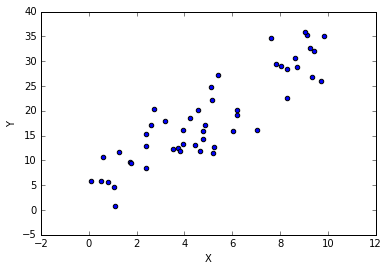

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# 生成数据
data_num = 50
X = np.random.rand(data_num, 1)*10
Y = 3*X + 4 + 4*np.random.randn(data_num,1)

# 画出数据的分布
plt.scatter(X, Y)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### 1.2 数学原理
有$N$个观测数据为：
$$
\mathbf{X} = \{x_1, x_2, ..., x_N \} \\
\mathbf{Y} = \{y_1, y_2, ..., y_N \}
$$
其中$\mathbf{X}$为自变量，$\mathbf{Y}$为因变量。

希望找到一个模型能够解释这些数据，假设使用最简单的线性模型来拟合数据：
$$
y = ax + b
$$
那么问题就变成求解参数$a$, $b$能够使得模型输出尽可能和观测数据有比较小的误差。

如何构建函数来评估模型输出与观测数据之间的误差是一个关键问题，这里使用观测数据与模型输出的平方和来作为评估函数（也被称为损失函数Loss function):
$$
L = \sum_{i=1}^{N} \{y_i - (a x_i + b)\}^2 \\
L = \sum_{i=1}^{N} (y_i - a x_i - b)^2 
$$

使误差函数最小，就可以求出模型的参数:
$$
\frac{\partial L}{\partial a} = -2 \sum_{i=1}^{N} (y_i - a x_i - b) x_i \\
\frac{\partial L}{\partial b} = -2 \sum_{i=1}^{N} (y_i - a x_i - b)
$$

即当偏微分为0时，误差函数为最小，可以得到:
$$
-2 \sum_{i=1}^{N} (y_i - a x_i - b) x_i = 0 \\
-2 \sum_{i=1}^{N} (y_i - a x_i - b) = 0 \\
$$

将上式调整一下顺序可以得到：
$$
a \sum x_i^2 + b \sum x_i = \sum y_i x_i \\
a \sum x_i + b N = \sum y_i
$$

上式中$\sum x_i^2$, $\sum x_i$, $\sum y_i$, $\sum y_i x_i$都是已知的数据，而参数$a$, $b$是想要求得未知参数。通过求解二元一次方程组，即可求出模型的最优参数。

### 1.3 求解程序

a = 2.807577, b = 4.540290


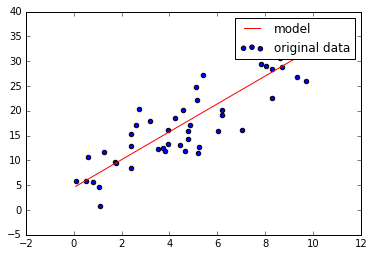

In [2]:
N = X.shape[0]

S_X2 = np.sum(X*X)
S_X  = np.sum(X)
S_XY = np.sum(X*Y)
S_Y  = np.sum(Y)

A = np.array([[S_X2, S_X], 
               [S_X, N]])
b = np.array([S_XY, S_Y])

# numpy.linalg模块包含线性代数的函数。Ax = b -> x = A^{-1}b
# 使用这个模块，可以计算逆矩阵、求特征值、解线性方程组以及求解行列式等。
coeff = np.linalg.inv(A).dot(b)

print('a = %f, b = %f' % (coeff[0], coeff[1]))

x_min = np.min(X)
x_max = np.max(X)
y_min = coeff[0] * x_min + coeff[1]
y_max = coeff[0] * x_max + coeff[1]

plt.scatter(X, Y, label='original data')
plt.plot([x_min, x_max], [y_min, y_max], 'r', label='model')
plt.legend()
plt.show()

## 2. 如何使用迭代的方法求出模型参数

当数据比较多的时候，或者模型比较复杂，无法直接使用解析的方式求出模型参数。因此更为常用的方式是，通过迭代的方式逐步逼近模型的参数。

### 2.1 梯度下降法
在机器学习算法中，对于很多监督学习模型，需要对原始的模型构建损失函数，接下来便是通过优化算法对损失函数进行优化，以便寻找到最优的参数。在求解机器学习参数的优化算法中，使用较多的是基于梯度下降的优化算法(Gradient Descent, GD)。

梯度下降法有很多优点，其中最主要的优点是，**在梯度下降法的求解过程中只需求解损失函数的一阶导数，计算的代价比较小，这使得梯度下降法能在很多大规模数据集上得到应用。**

梯度下降法的基本思想可以类比为一个下山的过程。假设这样一个场景：
* 一个人被困在山上，需要从山上下来，找到山的最低点，也就是山谷；
* 但此时山上的浓雾很大，导致可视度很低。因此，下山的路径就无法全部确定，他必须利用自己周围的信息去找到下山的路径。
* 以他当前的所处的位置为基准，寻找这个位置最陡峭的地方，然后朝着山的高度下降的地方走
* 每走一段距离，都反复采用同一个方法，最后就能成功的抵达山谷。


一般情况下，这座山最陡峭的地方是无法通过肉眼立马观察出来的，而是需要一个工具来测量；同时，这个人此时正好拥有测量出最陡峭方向的能力。所以，此人每走一段距离，都需要一段时间来测量所在位置最陡峭的方向，这是比较耗时的。那么为了在太阳下山之前到达山底，就要尽可能的减少测量方向的次数。这是一个两难的选择，如果测量的频繁，可以保证下山的方向是绝对正确的，但又非常耗时；如果测量的过少，又有偏离轨道的风险。所以需要找到一个合适的测量方向的频率，来确保下山的方向不错误，同时又不至于耗时太多！


![gradient_descent](images/gradient_descent.png)

如上图所示，得到了最优解。$x$,$y$表示的是$\theta_0$和$\theta_1$，$z$方向表示的是花费函数，很明显出发点不同，最后到达的收敛点可能不一样。当然如果是碗状的，那么收敛点就应该是一样的。

对于最小二乘的损失函数
$$
L = \sum_{i=1}^{N} (y_i - a x_i - b)^2
$$

更新的策略是：
$$
\theta \leftarrow \theta - \eta \triangledown L(\theta)
$$
其中$\theta$代表了模型中的参数，例如$a$, $b$

此公式的意义是：$L$是关于$\theta$的一个函数，当前所处的位置为$\theta_0$点，要从这个点走到L的最小值点，也就是山底。首先先确定前进的方向，也就是梯度的反向，然后走一段距离的步长，也就是$\eta$，走完这个段步长，就到达了$\theta_1$这个点！

最终的更新方程是：

$$
a \leftarrow a + 2 \eta [ y - (ax+b)]*x \\
b \leftarrow b + 2 \eta [ y - (ax+b)] 
$$

下面就这个公式的几个常见的疑问：

* **$\eta$是什么含义？**
$\eta$在梯度下降算法中被称作为学习率或者步长，意味着我们可以通过$\eta$来控制每一步走的距离，以保证不要步子跨的太大，错过了最低点；同时也要保证不要走的太慢，导致太阳下山了，还没有走到山下。所以$\eta$的选择在梯度下降法中往往是很重要的。
![gd_stepsize](images/gd_stepsize.png)

* **为什么要梯度要乘以一个负号？**
梯度前加一个负号，就意味着朝着梯度相反的方向前进！梯度的方向实际就是函数在此点上升最快的方向，而我们需要朝着下降最快的方向走，自然就是负的梯度的方向，所以此处需要加上负号。



### 2.2 示例代码

epoch    0: loss = 1038.185239, a = 3.184982, b = 1.368157
epoch  100: loss = 912.653889, a = 2.766009, b = 4.224919
epoch  200: loss = 900.102599, a = 2.849353, b = 4.483153
epoch  300: loss = 911.839292, a = 2.903715, b = 4.501834
epoch  400: loss = 904.394614, a = 2.875698, b = 4.491004


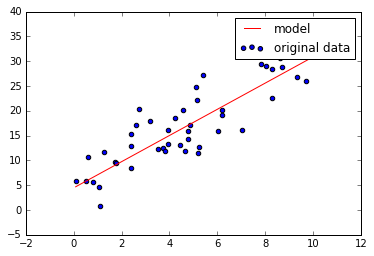

In [3]:
import random

n_epoch = 500          # epoch size
a, b = 1, 1            # initial parameters
epsilon = 0.001         # learning rate

for i in range(n_epoch):
    data_idx = list(range(N))
    random.shuffle(data_idx)
    
    for j in data_idx:
        a = a + epsilon*2*(Y[j] - a*X[j] - b)*X[j]
        b = b + epsilon*2*(Y[j] - a*X[j] - b)

    L = 0
    for j in range(N):
        L = L + (Y[j]-a*X[j]-b)**2
    
    if i % 100 == 0:
        print("epoch %4d: loss = %f, a = %f, b = %f" % (i, L, a, b))
    
x_min = np.min(X)
x_max = np.max(X)
y_min = a * x_min + b
y_max = a * x_max + b

plt.scatter(X, Y, label='original data')
plt.plot([x_min, x_max], [y_min, y_max], 'r', label='model')
plt.legend()
plt.show()

## 3. 如何可视化迭代过程

<IPython.core.display.Javascript object>


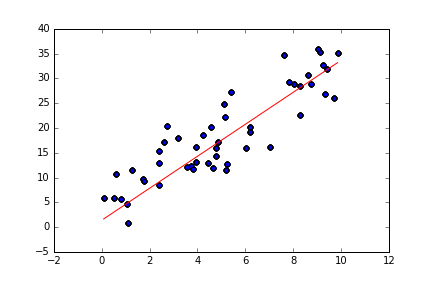

In [5]:
%matplotlib nbagg

import matplotlib.pyplot as plt
import matplotlib.animation as animation

n_epoch = 300          # epoch size
a, b = 1, 1             # initial parameters
epsilon = 0.0001         # learning rate

fig = plt.figure()
imgs = []

for i in range(n_epoch):
    data_idx = list(range(N))
    random.shuffle(data_idx)
    
    for j in data_idx[:10]:
        a = a + epsilon*2*(Y[j] - a*X[j] - b)*X[j]
        b = b + epsilon*2*(Y[j] - a*X[j] - b)


    if i<80 and i % 5 == 0:
        x_min = np.min(X)
        x_max = np.max(X)
        y_min = a * x_min + b
        y_max = a * x_max + b

        img = plt.scatter(X, Y, label='original data')
        img = plt.plot([x_min, x_max], [y_min, y_max], 'r', label='model')
        imgs.append(img)
        
ani = animation.ArtistAnimation(fig, imgs)
plt.show()

## 4. 如何使用批次更新的方法？

如果有一些数据包含比较大的错误（异常数据），因此每次更新仅仅使用一个数据会导致不精确，同时每次仅仅使用一个数据来计算更新也导致计算效率比较低。


* [梯度下降方法的几种形式](https://blog.csdn.net/u010402786/article/details/51188876)

## 5. 如何拟合多项式函数？

需要设计一个弹道导弹防御系统，通过观测导弹的飞行路径，预测未来导弹的飞行轨迹，从而完成摧毁的任务。按照物理学，可以得知模型为:
$$
y = at^2 + bt + c
$$
我们需要求解三个模型参数$a, b, c$。

损失函数的定义为：
$$
L = \sum_{i=1}^N (y_i - at_i^2 - bt_i - c)^2
$$


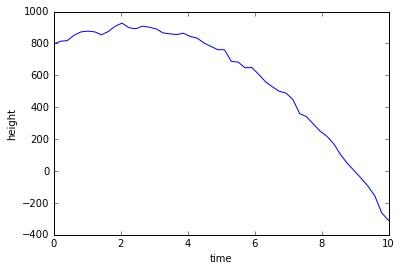

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

pa = -20
pb = 90
pc = 800

t = np.linspace(0, 10) 
y = pa*t**2 + pb*t + pc + np.random.randn(np.size(t))*15


plt.plot(t, y)
plt.xlabel("time")
plt.ylabel("height")
plt.savefig("fig-res-missle_taj.pdf")
plt.show()

### 5.1 如何得到更新项?

$$
L = \sum_{i=1}^N (y_i - at_i^2 - bt_i - c)^2
$$

\begin{eqnarray}
\frac{\partial L}{\partial a} & = & - 2\sum_{i=1}^N (y_i - at_i^2 - bt_i -c) t_i^2 \\
\frac{\partial L}{\partial b} & = & - 2\sum_{i=1}^N (y_i - at_i^2 - bt_i -c) t_i \\
\frac{\partial L}{\partial c} & = & - 2\sum_{i=1}^N (y_i - at_i^2 - bt_i -c)
\end{eqnarray}

### 5.2 程序

epoch    0: loss = 2.53846e+07, a =   -3.58006, b =     6.9891, c =    4.32586
epoch  500: loss = 1.05665e+06, a =   -30.2265, b =    234.342, c =    428.307
epoch 1000: loss =     349104, a =    -25.262, b =    167.861, c =     593.13
epoch 1500: loss =     122233, a =   -22.4341, b =    129.995, c =    686.988
epoch 2000: loss =    50146.4, a =   -20.8236, b =    108.431, c =    740.437
epoch 2500: loss =    27615.5, a =   -19.9065, b =    96.1514, c =    770.874


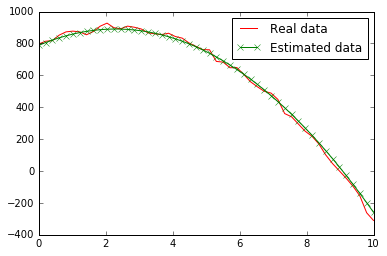

In [7]:
n_epoch = 3000              # epoch size
a, b, c = 1.0, 1.0, 1.0     # initial parameters
epsilon = 0.0001            # learning rate

N = np.size(t)

for i in range(n_epoch):
    for j in range(N):
        a = a + epsilon*2*(y[j] - a*t[j]**2 - b*t[j] - c)*t[j]**2
        b = b + epsilon*2*(y[j] - a*t[j]**2 - b*t[j] - c)*t[j]
        c = c + epsilon*2*(y[j] - a*t[j]**2 - b*t[j] - c)

    L = 0
    for j in range(N):
        L = L + (y[j] - a*t[j]**2 - b*t[j] - c)**2
    
    if i % 500 == 0:
        print("epoch %4d: loss = %10g, a = %10g, b = %10g, c = %10g" % (i, L, a, b, c))
    
    
y_est = a*t**2 + b*t + c 


plt.plot(t, y, 'r-', label='Real data')
plt.plot(t, y_est, 'g-x', label='Estimated data')
plt.legend()
plt.savefig("fig-res-missle_est.pdf")
plt.show()


## 6. 如何使用sklearn求解线性问题？


X:  (100, 1)
Y:  (100, 1)
a = 1.978962, b = 8.098165


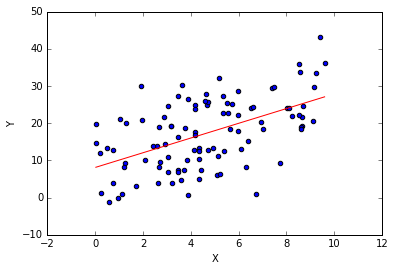

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

# load data
# generate data
data_num = 100
X = np.random.rand(data_num, 1)*10
Y = X * 3 + 4 + 8*np.random.randn(data_num,1)

print("X: ", X.shape)
print("Y: ", Y.shape)

# create regression model
regr = linear_model.LinearRegression()
regr.fit(X, Y)

a, b = np.squeeze(regr.coef_), np.squeeze(regr.intercept_)

print("a = %f, b = %f" % (a, b))

x_min = np.min(X)
x_max = np.max(X)
y_min = a * x_min + b
y_max = a * x_max + b

plt.scatter(X, Y)
plt.plot([x_min, x_max], [y_min, y_max], 'r')
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("fig-res-sklearn_linear_fitting.pdf")
plt.show()

## 7. 如何使用sklearn拟合多项式函数？

In [10]:
# Fitting polynomial functions

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

t = np.array([2, 4, 6, 8])

pa = -20
pb = 90
pc = 800

y = pa*t**2 + pb*t + pc

model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(t[:, np.newaxis], y)
model.named_steps['linear'].coef_


array([800.,  90., -20.])

## 参考资料
* [梯度下降法](https://blog.csdn.net/u010402786/article/details/51188876)
* [如何理解最小二乘法？](https://blog.csdn.net/ccnt_2012/article/details/81127117)
